### IMPORT DEPENDENCIES

In [10]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

### setting Constants

In [11]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 2

### Directory Path

In [12]:
directory_path = r'/Users/macbook/Desktop/Hackathon/Crop Diseases Dataset/Crop Diseases/Crop___Disease'

### import data into tensorflow

In [13]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory_path,
    shuffle="True",
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE)

Found 13324 files belonging to 17 classes.


In [14]:
class_names=dataset.class_names
class_names

['Corn___Common_Rust',
 'Corn___Gray_Leaf_Spot',
 'Corn___Healthy',
 'Corn___Northern_Leaf_Blight',
 'Potato___Early_Blight',
 'Potato___Healthy',
 'Potato___Late_Blight',
 'Rice___Brown_Spot',
 'Rice___Healthy',
 'Rice___Leaf_Blast',
 'Rice___Neck_Blast',
 'Sugarcane Bacterial Blight',
 'Sugarcane Healthy',
 'Sugarcane Red Rot',
 'Wheat___Brown_Rust',
 'Wheat___Healthy',
 'Wheat___Yellow_Rust']

In [15]:
len(dataset)

417

In [16]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[ 8  4  1 16  3  0  4  6 15 14  9  2  2 15 15  0  0  3  2  1 14 14 16  2
  7  8  8  6 15  6  0  6]


### DATA VISUALIZATION

In [17]:
plt.figure(figsize=(10,10))
from numpy import uint16
for image_batch, label_batch in dataset.take(1):
  for i in range(12):
      plt.subplot(3,4,i+1)
      plt.imshow(image_batch[i].numpy().astype("uint8"))
      plt.title(class_names[label_batch[i]])
      plt.axis("off")

### TRAIN TEST SPLIT

<p>80 % TRAINING

20 % VALIDATION (10% validation + 10% Test)

Function to Divide Dataset into train , validation and test</p>

In [18]:
def get_dataset_partitions_tf(dataset, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(dataset)

    if shuffle:
        daaset = dataset.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_dataset = dataset.take(train_size)
    val_dataset = dataset.skip(train_size).take(val_size)
    test_dataset = dataset.skip(train_size).skip(val_size)

    return train_dataset, val_dataset, test_dataset

In [19]:
train_dataset, val_dataset, test_dataset = get_dataset_partitions_tf(dataset)

In [20]:
len(train_dataset)

333

In [21]:
len(val_dataset)

41

In [22]:
len(test_dataset)

43

### Cache, Shuffle, and Prefetch Dataset

In [23]:
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## BUILDING MODEL

### RESIZE & RESCALE

In [24]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

### DATA AUGMENTATION

In [29]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomContrast(0.1),
    tf.keras.layers.RandomBrightness(0.1)
#     layers.experimental.RandomBrightness(0.1)
])


### MODEL ARCHITECTURE

In [23]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 17

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    
    layers.Conv2D(32,(3,3), padding="valid", activation="relu",input_shape=input_shape),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2),padding="valid", strides=2),
    
    layers.Conv2D(64,  kernel_size = (3,3), padding="valid" , activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2),padding="valid", strides=2),
    
    layers.Conv2D(64,  kernel_size = (3,3), padding="valid" , activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2),padding="valid", strides=2),
    
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])
model.build(input_shape=input_shape)

In [24]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 256, 256, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 128, 128, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 128, 128, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 64, 64, 64)          0         
 g2D)                                                 

### Model Complilation


<p>We use adam Optimizer, SparseCategoricalCrossentropy for losses, accuracy as a metric</p>

In [25]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [26]:
history = model.fit(
    train_dataset,
    batch_size=BATCH_SIZE,
    validation_data=val_dataset,
    epochs=EPOCHS,
)

Epoch 1/2


2024-03-12 22:39:34.107934: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:82: Filling up shuffle buffer (this may take a while): 63 of 1000
2024-03-12 22:39:44.158082: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:82: Filling up shuffle buffer (this may take a while): 134 of 1000
2024-03-12 22:40:04.179144: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:82: Filling up shuffle buffer (this may take a while): 270 of 1000
2024-03-12 22:40:13.661486: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


333/333 [==============================] - ETA: 0s - loss: 1.2756 - accuracy: 0.5321

2024-03-12 22:44:34.462505: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:85: Filling up shuffle buffer (this may take a while): 1 of 1000
2024-03-12 22:44:41.299069: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


333/333 [==============================] - 325s 823ms/step - loss: 1.2756 - accuracy: 0.5321 - val_loss: 0.8477 - val_accuracy: 0.6860
Epoch 2/2
333/333 [==============================] - 224s 672ms/step - loss: 0.6878 - accuracy: 0.7314 - val_loss: 0.7991 - val_accuracy: 0.6944


In [27]:
result = model.evaluate(test_dataset)

2024-03-12 22:49:26.332094: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:88: Filling up shuffle buffer (this may take a while): 1 of 1000
2024-03-12 22:49:30.619911: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


43/43 [==============================] - 65s 159ms/step - loss: 0.7698 - accuracy: 0.7006


In [28]:
result

[0.7697980999946594, 0.7005899548530579]

In [29]:
history.params

{'verbose': 1, 'epochs': 2, 'steps': 333}

In [30]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [31]:
accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

loss = history.history['loss']
validation_loss = history.history['val_loss']

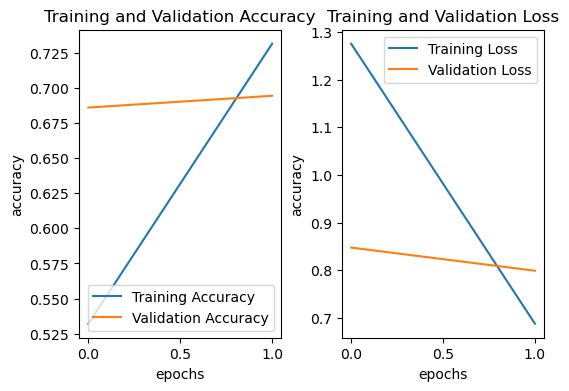

In [32]:
plt.figure(figsize=(6, 4))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), accuracy, label='Training Accuracy')
plt.plot(range(EPOCHS), validation_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), validation_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.title('Training and Validation Loss')
plt.subplots_adjust(wspace=0.3)
plt.show()

### Running Prediction on sample images

In [33]:
import numpy as np
def predict(model, image):
    image_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    image_array = tf.expand_dims(image_array, 0)

    predictions = model.predict(image_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 17ms/step


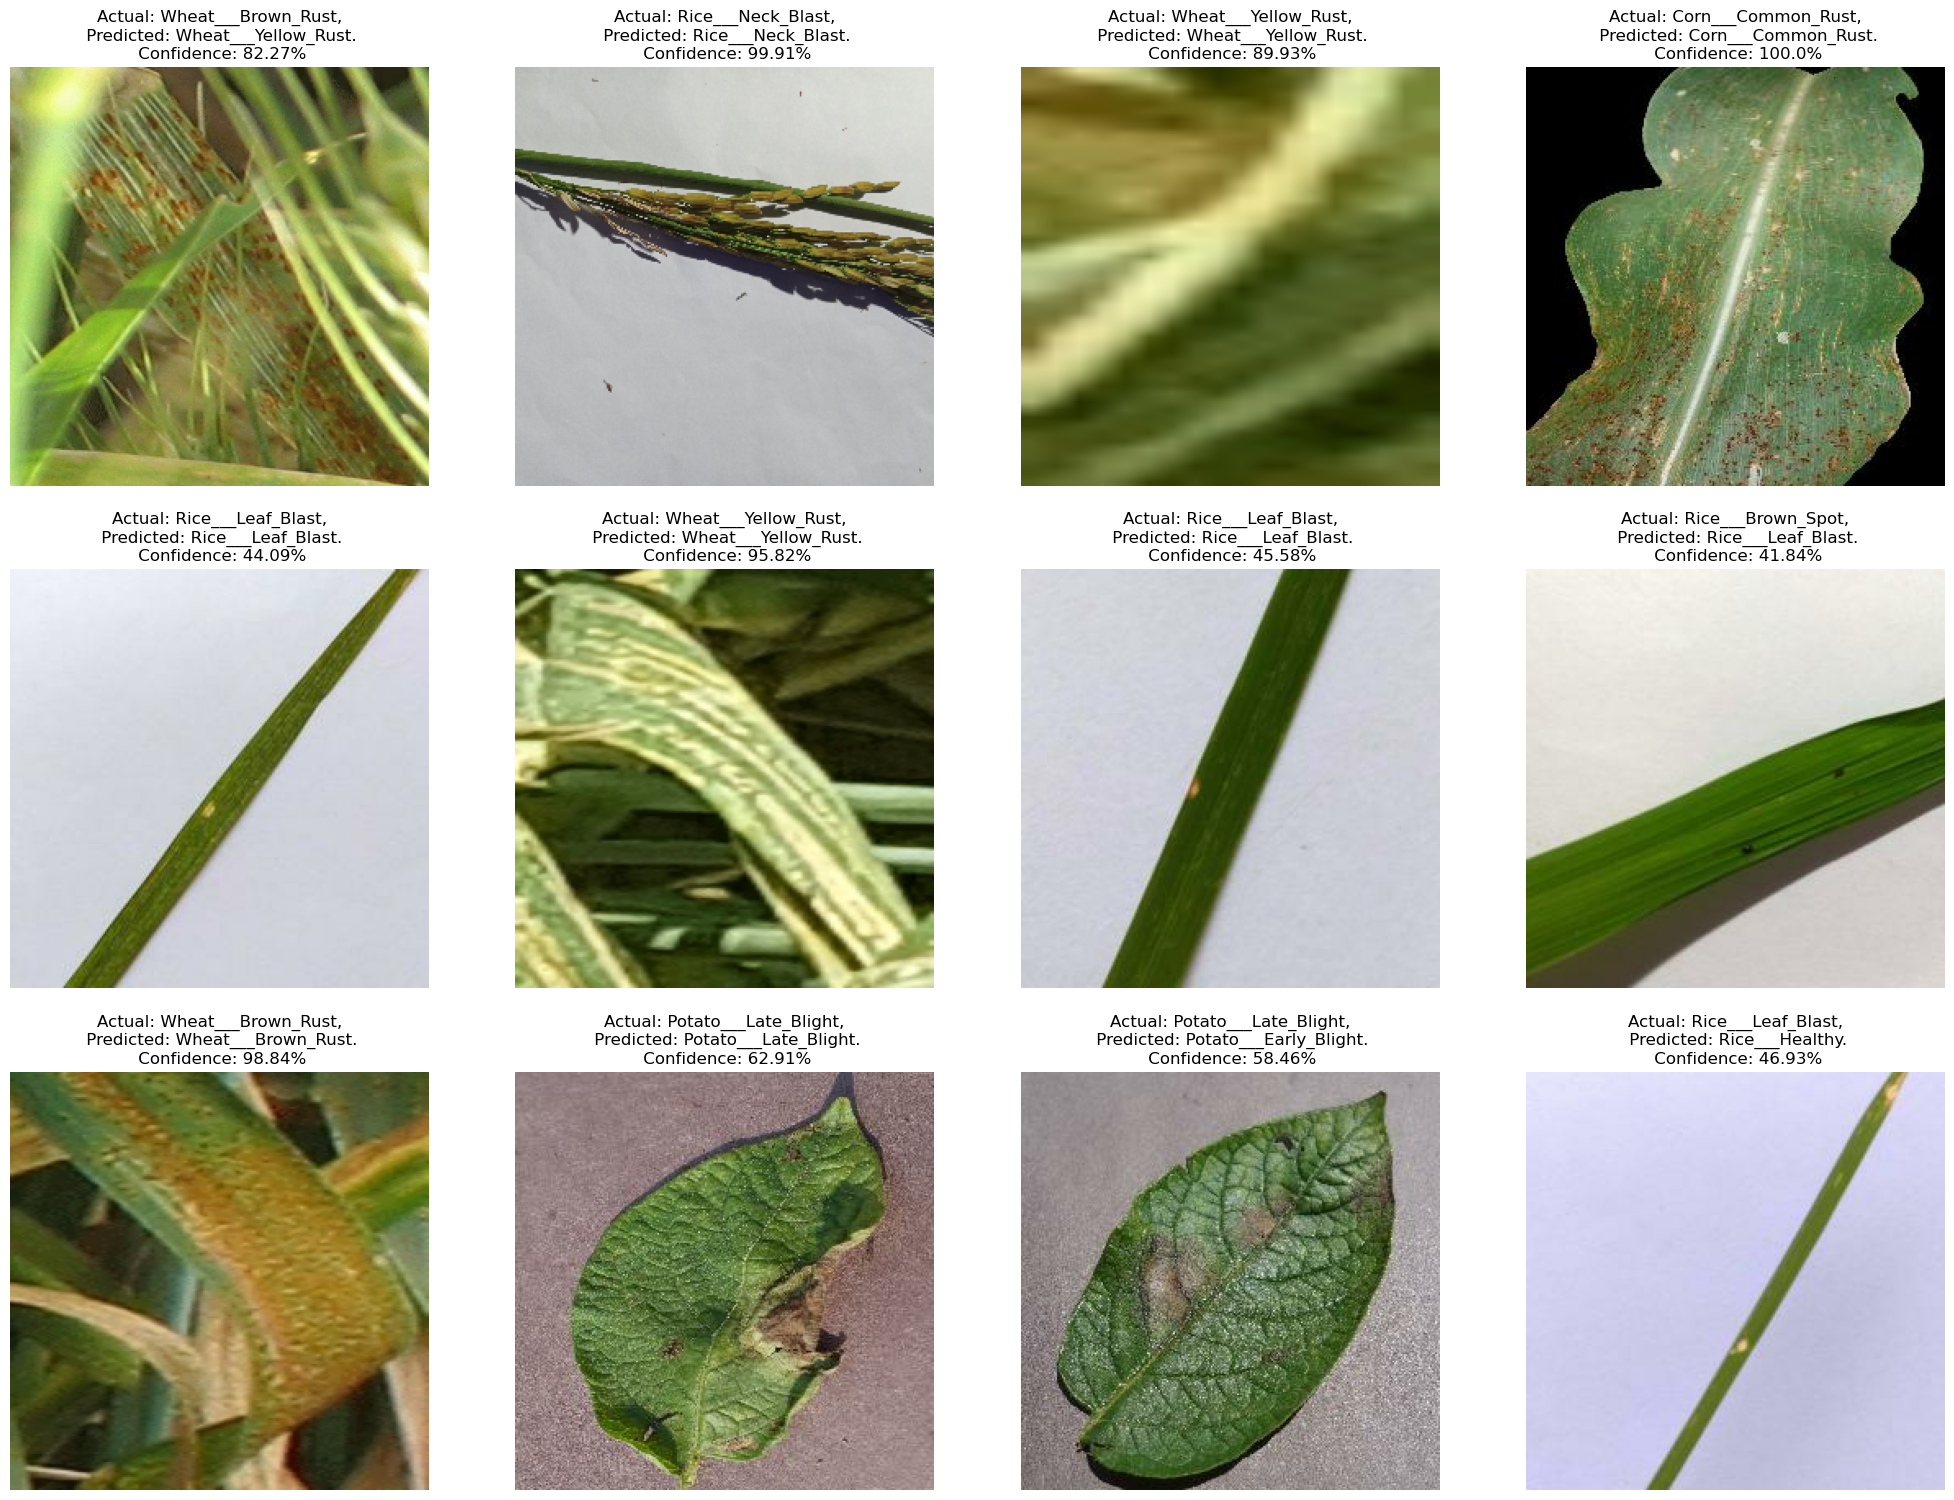

In [34]:
plt.figure(figsize=(25, 25))
for images, labels in test_dataset.take(1):
    for i in range(12):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [35]:
import tensorflow as tf

# Assuming you have a TensorFlow model named 'model'

# Save the model as an HDF5 file
model.save("model.h5")

# If you want to save as a pickle file (not recommended for TensorFlow models)
import pickle

with open("model.pkl", "wb") as f:
    pickle.dump(model, f)

/Users/macbook/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [39]:
import tensorflow as tf
from tensorflow.keras.models import Sequential  # Or your model architecture (e.g., Functional)

# Create or load your Keras model (replace with your actual model creation/loading code)
model = Sequential(...)  # For a sequential model

# Save the model
model.save("crop_model.h5")  # Replace with the desired filename and extension


AttributeError: 'Sequential' object has no attribute 'tf'

### Loading the model and predicting 

__Output__: Numpy Array

In [47]:
import joblib
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np

# Load the pickle model
def load_pickle_model(model_path):
    return joblib.load(model_path)

# Load the HDF5 model
def load_hdf5_model(model_path):
    return tf.keras.models.load_model(model_path)

# Preprocess the image
def preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(256, 256))  # adjust target_size to match model input size
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# Test the model
def test_model(model, image_path):
    img = preprocess_image(image_path)
    prediction = model.predict(img)
    return prediction

# Example usage
if __name__ == "__main__":
    # Load models

    hdf5_model = load_hdf5_model('/Users/macbook/Desktop/Hackathon/model.h5')

    # Test images
    image_path = '/Users/macbook/Desktop/PUCODE/Dataset_crop_detection/train/Rice___Leaf_Blast/rb_wb_11.jpg'  # Provide the path to your test image



    # Test HDF5 model
    hdf5_prediction = test_model(hdf5_model, image_path)
    print("Prediction using HDF5 model:", hdf5_prediction)


1/1 [==============================] - 0s 111ms/step
Prediction using HDF5 model: [[1.07158429e-03 5.33471815e-04 5.27158089e-04 2.52321418e-02
  2.08407594e-03 7.79075417e-05 7.34342355e-03 1.66080594e-02
  3.21327103e-03 1.22726252e-02 9.24388349e-01 3.42793530e-04
  2.65483232e-03 8.87620496e-04 1.89399859e-03 7.60459341e-04
  1.08145345e-04]]


---
__Output__: Actual Predicted class

In [51]:
import joblib
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
# Define your class names
# class_names = ['class1', 'class2', 'class3']  # Replace with your actual class names

class_names = [
    "Corn___Common_Rust",  
    "Corn___Gray_Leaf_Spot",
    "Corn___Healthy",
    "Corn___Northern_Leaf_Blight",
    "Potato___Early_Blight",
    "Potato___Healthy",
    "Potato___Late_Blight",
    "Rice___Brown_Spot",
    "Rice___Healthy",
    "Rice___Leaf_Blast",
    "Rice___Neck_Blast",
    "Sugarcane Bacterial Blight",
    "Sugarcane Healthy",
    "Sugarcane Red Rot",
    "Wheat___Brown_Rust",
    "Wheat___Healthy",
    "Wheat___Yellow_Rust",
]

# Load the pickle model
def load_pickle_model(model_path):
    return joblib.load(model_path)

# Load the HDF5 model
def load_hdf5_model(model_path):
    return tf.keras.models.load_model(model_path)

# Preprocess the image
def preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(256, 256))  # adjust target_size to match model input size
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# Test the model
def test_model_with_labels(model, image_path, class_names):
    img = preprocess_image(image_path)
    prediction = model.predict(img)
    predicted_class_index = np.argmax(prediction)
    predicted_class = class_names[predicted_class_index]
    return predicted_class

# Example usage
if __name__ == "__main__":

    hdf5_model = load_hdf5_model('/Users/macbook/Desktop/Hackathon/model.h5')
    print(hdf5_model)

    # Test images
    image_path = '/Users/macbook/Desktop/Brown rust symptoms in wheat.jpg'  # Provide the path to your test image


    # Test HDF5 model
    hdf5_predicted_class = test_model_with_labels(hdf5_model, image_path, class_names)
    print("Prediction using HDF5 model:", hdf5_predicted_class)


1/1 [==============================] - 0s 103ms/step
Prediction using HDF5 model: Wheat___Brown_Rust


In [55]:
model.save('my_model_xyz', save_format='tf')


INFO:tensorflow:Assets written to: my_model_xyz/assets


INFO:tensorflow:Assets written to: my_model_xyz/assets
